In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import os
import glob
from tensorflow.python.client import device_lib
import tensorflow as tf
# print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


In [2]:
############## 수정
import numpy as np
from tqdm import tqdm
import os

# dataset 폴더 경로 설정
# PATH = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'
PATH = r'C:\Users\oem\Desktop\jhy\dataset'

# dataset 폴더 아래의 모든 폴더 목록을 얻기
actions = [folder for folder in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, folder))]
# 결과 출력
print(len(actions), actions)

label_mapping = {action: idx for idx, action in enumerate(actions)}

#  = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'
# PATH = r'C:\Users\oem\Desktop\jhy\dataset'

data = []
labels = []

for action in tqdm(actions):
    PATH2 = f'{PATH}/{action}'
    file_path = glob.glob(os.path.join(PATH2, f'seq_*.npy'))[0]
    try:
        loaded_data = np.load(file_path, allow_pickle=True)
        data.append(loaded_data)

        label = np.full((loaded_data.shape[0],), label_mapping[action])
        labels.append(label)
    except FileNotFoundError:
        print(f"File not found for action: {action}")

x_data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)


559 ['(Blood) circulation', '(English text) Poetry', '(Eyes)', '(Facility) Bridge', '(Liver to food)', '(Shooting gun)', '(Temperature)', '-bang', '-do', '-jean', '-soup', 'a drawer', 'Acacia flower', 'Accept', 'acceptance', 'Accomplice', 'acorn', 'affectation', 'again', 'Agent', 'Aggression', 'air conditioner', 'air Force', 'airline', 'alcohol', 'All night', 'alley', 'allure', 'Anatomy', 'Anniversary', 'answer', 'appear', 'applicant', 'argent', 'arithmetic', 'army', 'army unit', 'artist', 'Assistant dog', 'Association', "Athlete's village", 'attache', 'back', 'balance', 'ball', 'bandage', 'Bank book', 'barbershop', 'bath', 'Be', 'Be huge', 'Be insignificant', 'Be persistent', 'Beach', 'because', 'Beetle', 'behavior', 'Bend', 'beset', 'Blind school', 'Blood donation', 'Blood flesh', 'blood type', 'Body movement', 'bone', 'boring', 'breakthrough', 'bribe', 'brick', 'Brother-in-law', 'buddhism', 'Bulguksa Temple', 'business trip', 'button', 'camera', 'card', 'cassette', 'Celadon', 'Cell 

 74%|███████▍  | 414/559 [00:44<00:15,  9.23it/s]


KeyboardInterrupt: 

In [2]:
import numpy as np
from tqdm import tqdm
import os
import glob  # glob 라이브러리 추가

# dataset 폴더 경로 설정
# PATH = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'
PATH = r'C:\Users\oem\Desktop\jhy\dataset'

# dataset 폴더 아래의 모든 폴더 목록을 얻기
actions = []  # 변경된 부분
label_mapping = {}  # 변경된 부분

for folder in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, folder)):
        # 각 폴더에 있는 npy 파일들을 확인
        npy_files = glob.glob(os.path.join(PATH, folder, 'seq_*.npy'))
        
        # 특정 조건에 맞는 npy 파일이 존재하면 actions와 label_mapping에 추가
        if npy_files:
            actions.append(folder)
            label_mapping[folder] = len(actions) - 1

# 결과 출력
print(len(actions), actions)

data = []
labels = []

for action in tqdm(actions):
    PATH2 = os.path.join(PATH, action)
    file_path = glob.glob(os.path.join(PATH2, f'seq_*.npy'))[0]
    try:
        loaded_data = np.load(file_path, allow_pickle=True)
        data.append(loaded_data)

        label = np.full((loaded_data.shape[0],), label_mapping[action])
        labels.append(label)
    except FileNotFoundError:
        print(f"File not found for action: {action}")

x_data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
print(y_data.shape)


from sklearn.model_selection import train_test_split

# data를 train과 test로 나눔
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test의 크기 확인
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# 데이터 준비

921 ['(Blood) circulation', '(Body) legs', '(Drinking) tea', '(English text) Poetry', '(Eyes)', '(Facility) Bridge', '(Gas fire)', '(Hat)', '(Liver to food)', '(Percussion)', '(Shooting gun)', '(Temperature)', '(Time) minute', '(Time) Poetry', '-bang', '-coffin', '-do', '-jean', '-soup', 'a drawer', 'abolition', 'Acacia flower', 'Accept', 'acceptance', 'Accomplice', 'Accused', 'acorn', 'admit', 'advice', 'affectation', 'again', 'Agent', 'Aggression', 'air conditioner', 'air Force', 'airline', 'album', 'alcohol', 'all', 'All night', 'alley', 'allure', 'analogy', 'analyze', 'Anatomy', 'animal', 'Anniversary', 'answer', 'any', 'appear', 'applicant', 'April', 'Archery', 'argent', 'Argentina', 'arithmetic', 'Armenia', 'army', 'army unit', 'artist', 'assembly', 'Assistant dog', 'Association', 'athlete', "Athlete's village", 'attache', 'August', 'aunt', 'author', 'authority', 'autumn', 'back', 'Badinage', 'bake', 'bakery', 'balance', 'ball', 'ballet', 'Bamani', 'bandage', 'Bank book', 'barber

100%|██████████| 921/921 [01:18<00:00, 11.79it/s]


(2423214, 921)
x_train shape: (1938571, 30, 156)
y_train shape: (1938571, 921)
x_test shape: (484643, 30, 156)
y_test shape: (484643, 921)


In [4]:
#model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(32, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                24192     
                                                                 
 dense_1 (Dense)             (None, 921)               30393     
                                                                 
Total params: 54,585
Trainable params: 54,585
Non-trainable params: 0
_________________________________________________________________


In [4]:
# model 3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
strategy = tf.distribute.MirroredStrategy() # gpu 분산처리 2
with strategy.scope():
    model = Sequential([
        LSTM(128, activation='tanh', return_sequences=True, input_shape=x_train.shape[1:3]),
        Dropout(0.5),
        LSTM(64, activation='tanh', return_sequences=True),
        Dropout(0.5),
        LSTM(32, activation='tanh'),
        Dense(256, activation='relu'),
        Dropout(0.25),
        Dense(len(actions), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128

In [1]:
# model 3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=x_train.shape[1:3]),
    Dropout(0.5),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.5),
    LSTM(32, activation='tanh'),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

NameError: name 'x_train' is not defined

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

EPOCHS = 100

history = model.fit(
    x_train[:1000],
    y_train[:1000],
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    # batch_size = 1000,
    shuffle = False,
    # callbacks=[
    #     ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    #     ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    # ]
)

Epoch 1/100


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_1/lstm_1/PartitionedCall]] [Op:__inference_train_function_3510]

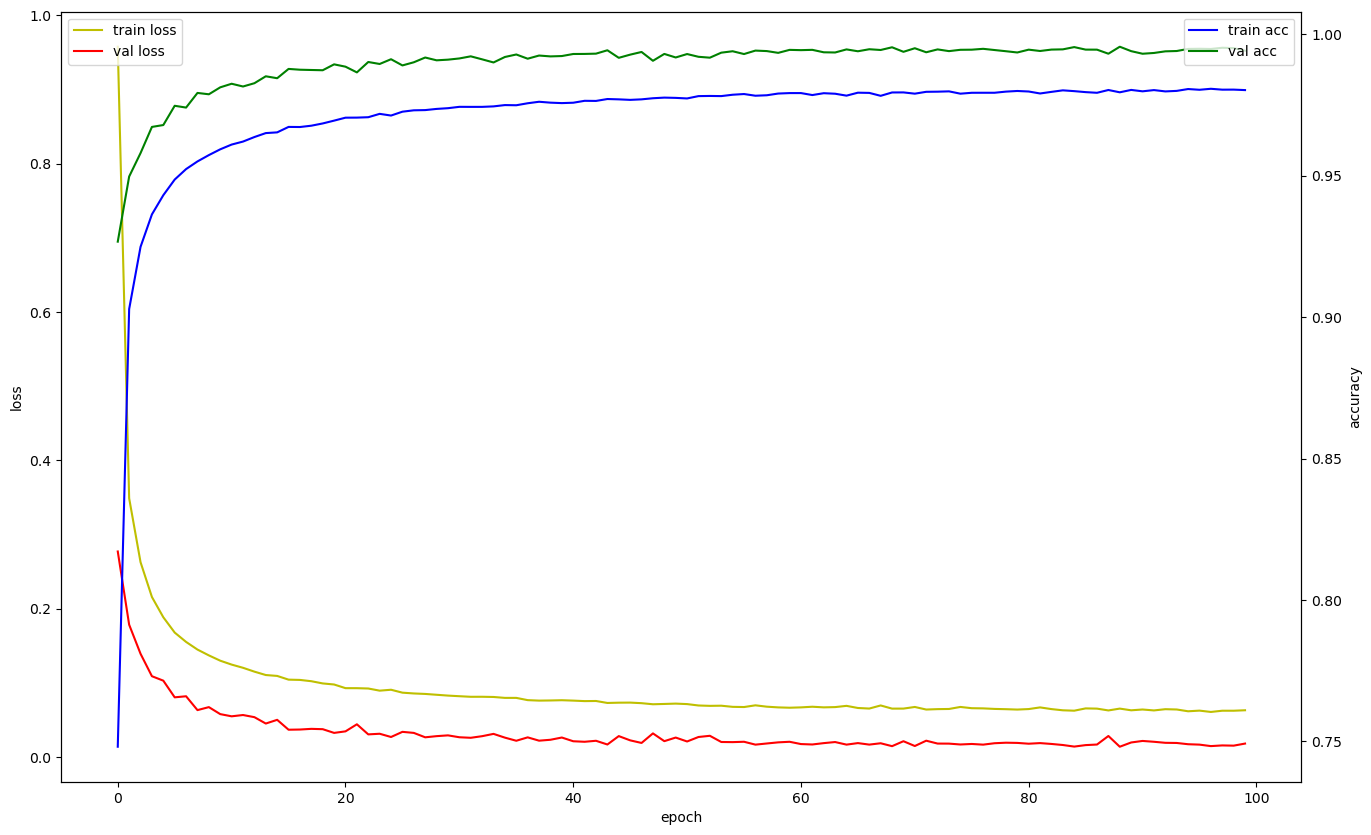

In [21]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [22]:
# model.save(f'/content/drive/MyDrive/LAB/Sign_Language_Remaster/model/lstm_test21_{len(actions)}_e{EPOCHS}.h5')
model.save(f'C:/Users/oem/Desktop/jhy/signlanguage/Sign_Language_Remaster/model/lstm_test31_{len(actions)}act_e{EPOCHS}.h5')

In [12]:
from sklearn.metrics import accuracy_score
# model = load_model(f'/content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster/model/lstm_test8_e100.h5')
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)


Accuracy: 0.9973073916442282
